In [2]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip3 install torchtext
!pip3 install torchvision
!pip3 install --no-cache-dir -I pillow
!pip install python-resize-image


    100% |████████████████████████████████| 2.0MB 2.5MB/s 


# Image Project


#### Students:
* Riccardo Menoli (Student-ID: 014963230)
* Stefano Lia (Student-ID: 014962723)
* Tafseer Ahmed (Student-ID: 014973194)

In [0]:
# Download of all files

import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile


train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    
    #os.unlink(zip_path)

In [4]:
# workaround 
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

# All necessary imports

%matplotlib inline

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg

# displaying inline pandas images
import glob
import random
import base64
from io import BytesIO
from IPython.display import HTML

pd.set_option('display.max_colwidth', -1)

from os import listdir
from os.path import isfile, join

import seaborn as sns

import PIL
print(PIL.PILLOW_VERSION)

5.4.1


In [0]:
# GLOBAL FUNCTIONS

def plot_image(tensor):
  if tensor.shape[0] == 3:
    x = tensor.permute(1,2,0).data.numpy()
    plt.imshow(x)
  elif tensor.shape[0] == 1:
    x = tensor.permute(1,2,0).squeeze(2).data.numpy()
    plt.imshow(x, cmap='gray')

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i
  
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'


# create vector classes in df  
  
def vec2label (df):
  l = []
  for i in range(df.shape[0]):
    p = []
    for k in df.columns[1:-1]:
      if df.loc[i][f'{k}']:
        p.append(k)
    l.append(p)
  l = pd.Series(l)
  return l

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [0]:
# GLOBAL VARIABLES
path = 'train/annotations/'
classes = [f[:-4] for f in listdir(path) if isfile(join(path, f))]

## Data Management

### DataFrame

In [0]:
class Dataframe_builder:
  
  def __init__(self):
    
    # distribution of all the classes
    self.class_dist = dict([(f'{f[:-4]}',file_len(f'{path}{f}')) for f in listdir(path) if isfile(join(path, f))])
    
    self.df = self._create_df()
    print("insert PIL image in the dataframe...")
    self.df['image'] = self.df.fileName.map(lambda f: get_thumbnail(f))
    print("make classes column...")
    self.df['classes']= vec2label(self.df)
  
  def _create_df(self):
    # sort all the images from im1....imn
    file_col = listdir("train/images")
    list1 = [int(x[2:len(x)-4]) for x in file_col]
    list1.sort()
    listfin = ["train/images/im"+str(num)+".jpg" for num in list1]

    file_col = pd.Series(listfin)

    # creation of the dataframe 
    df = pd.DataFrame()
    df["fileName"] = file_col

    path = "train/annotations"
    row = 0

    # file dic contains how many samples there are for each class. Is it needed?
    file_dic = {}

    for label, filename in enumerate(listdir(path)):
      # array of zeros (20000,) that will be one column of the df
      tmp = np.zeros(file_col.shape[0], dtype=int)
      with open(path+"/"+filename, "r") as file:
        file_len = 0
        for line in file:
          # get the line that contains that image
          line = line.replace("\n", "")
          line = int(line)
          tmp[line-1] = 1   # set 1 for the image that contains that class 
          file_len = file_len + 1
      filename = filename[:-4]
      tmp = pd.Series(tmp)
      df[filename] = tmp
      file_dic[filename] = file_len
    
    
    return df
    # print(file_dic)
  
  def get_df(self):
    return self.df
  
  def del_missing_values(self):
    
    mask = df['classes'].astype(str) == '[]' 
    missing_values = sum(mask)
    print("missing values:", missing_values)
    
    # percentage of images without class
    print("Percentage missing values:", (missing_values/20000)*100)
    
    # delete all the values without target
    self.df = df[~mask]
    
  def plot_distribution(self):
    
    sns.set(style="ticks", color_codes=True)
    plt.figure(figsize=(15,7))
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.xlabel("Classes")
    plt.title(f"Distribution")
    plt.bar(self.class_dist.keys(), self.class_dist.values(), width=0.9, color='b')

In [8]:
# DATAFRAME

df_builder = Dataframe_builder()

df = df_builder.get_df() 

insert PIL image in the dataframe...
make classes column...


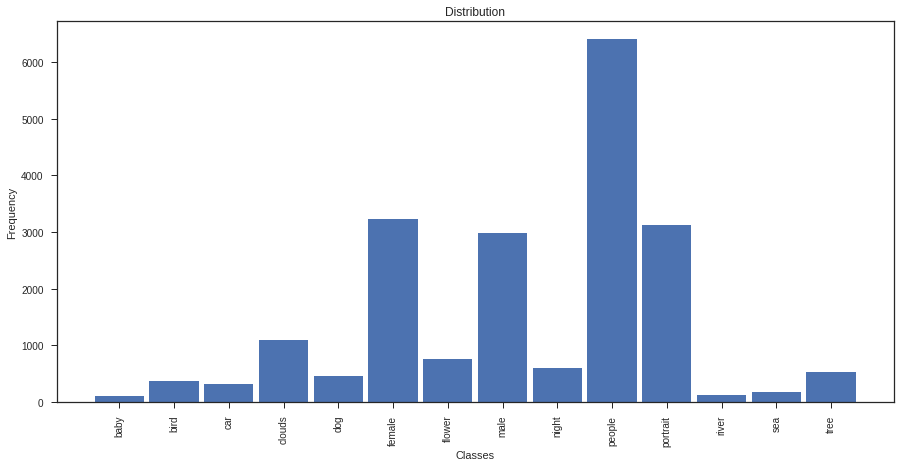

In [9]:
df_builder.plot_distribution()

### Missing values

Our first idea was to remove the samples with empty labels. But since sometimes we have to make empty predictions, we need to mantain them. Doing this we don't force the model to make always predictions, but also to recognize when an image doesn't have any class.

,fileName,image,classes
0,train/images/im1.jpg,,"[female, portrait, people]"
1,train/images/im2.jpg,,[]
2,train/images/im3.jpg,,[]
3,train/images/im4.jpg,,"[male, people]"
4,train/images/im5.jpg,,"[male, people]"
5,train/images/im6.jpg,,[]
6,train/images/im7.jpg,,"[female, people]"
7,train/images/im8.jpg,,[]
8,train/images/im9.jpg,,[]
9,train/images/im10.jpg,,[]

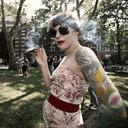
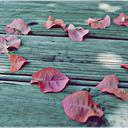
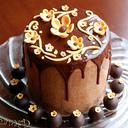
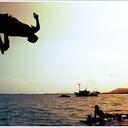
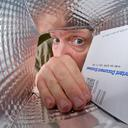
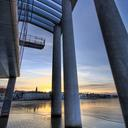
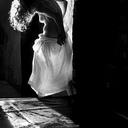
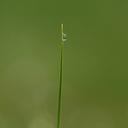
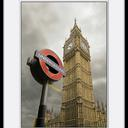
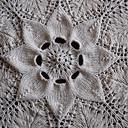
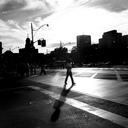
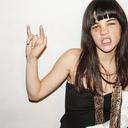
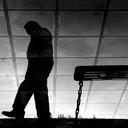
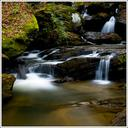
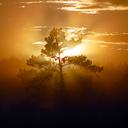
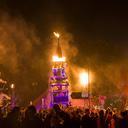
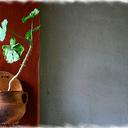
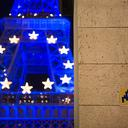
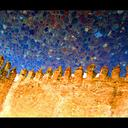
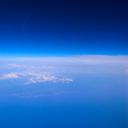

In [10]:
HTML(df[['fileName', 'image','classes']].head(20).to_html(formatters={'image': image_formatter}, escape=False))

In [0]:
# Save dataframe

df.to_csv("data.csv")

### Data Loader

In [0]:
###### IMAGE DATALOADER ######

# PREPARING THE DATALOADER
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings ?
import warnings
warnings.filterwarnings("ignore")
import operator
import ast

class ImageDataset:
  def __init__ (self, csv_file, transformations=None, resize=None):
    self.data_frame = pd.read_csv(csv_file)
    self.data_frame=self.data_frame.drop(['Unnamed: 0'], axis=1)
    self.to_tensor = transforms.ToTensor()
    # for data augmentation
    self.transformations = transformations
    self.resize = resize
      
  
  def __len__(self):
        return len(self.data_frame)
   
  def __getitem__(self, idx):
    
    # Get image name from the pandas df
    single_image_name = self.data_frame.iloc[idx,0]
    
    # Open image
    img_as_img = Image.open(single_image_name).convert("RGB")
    
    if self.resize:
      # resize = (224, 224) 
      img_as_img = img_as_img.resize(self.resize)
    if self.transformations:
      img_as_img = self.transformations(img_as_img)

    # Transform image to tensor
    img_as_tensor = self.to_tensor(img_as_img)
    
    labels = np.asarray(self.data_frame.iloc[idx,1:-2], dtype=np.int16)
    labels_classes = self.data_frame.iloc[idx,16]
    sample = dict({'image': img_as_tensor, 'labels': labels, 'classes':labels_classes})
    return (sample)
  
  def get_images_classes(self, c):
    
    images = []

    for key, value in self.data_frame['classes'].to_dict().items():
      if set(c).issubset(set(ast.literal_eval(value))):
        images.append(self.__getitem__(key))

    return images
  
  def get_all_imgs(self):
    images = []
    for row in df.iterrows():
      images.append(self.__getitem__(row[0]))
    
    return images

In [13]:
# percentage per class in the dataset now
class_df = df.iloc[ : , range(1,15)]
classes_entire_df = class_df.sum(axis=0)/class_df.shape[0]
print("Percentage of images per classes")
print(classes_entire_df*100)
print("\n")
print("Number of image per class")
print(class_df.sum(axis=0))

Percentage of images per classes
bird        1.800 
tree        2.625 
flower      3.805 
clouds      5.475 
female      16.135
river       0.600 
portrait    15.605
car         1.595 
male        14.895
dog         2.240 
night       2.990 
people      32.015
baby        0.475 
sea         0.865 
dtype: float64


Number of image per class
bird        360 
tree        525 
flower      761 
clouds      1095
female      3227
river       120 
portrait    3121
car         319 
male        2979
dog         448 
night       598 
people      6403
baby        95  
sea         173 
dtype: int64


### Splitting strategy: 

Each class has to appear in the training and validation set. The training set will contain 90% of the data and the remaining 10% will be in the validation set.
Our idea is to mantian more or less the same proportion of data in the training  and validation set. Unfortunately, this operation is not feasable in this senario due to the fact that the classes are hight correlated. In fact, we saw that when one of the classes "male" or "female" or "baby" appears usually appears also the class "people".



Our idea is to balance the dataset. That means having the same proportion of the classes in both the training and validation set repect to the initial distribution of the data. For example we want to have the same proportion of the images that have the label "baby". The problem is that there are some classes which are **less representative**, which means that we don't have several example of one image. So could be difficult to have a balanced training and test splitting randomly the whole dataset.
So, the classes that are most liked to not be present in a corret way in the training and in the validation set are the classes that are less rappresentative. (i.e. "Baby", "river", "sea",  "bird", "car").
To balance the dataset let's put constraint for this class in the splitting procedure in order to ensure the right rappresentation of each class in both training and test set.

In [14]:
# BALANCE THE DATASET
from sklearn.model_selection import train_test_split

train_data, validation_data = train_test_split(df, test_size=0.1)

# baby images are 95 --> 10% of 95 = 9.5
# river images are 120 --> 10% of 95 = 12
# river images are 173 --> 10% of 95 = 17
# baby images are 360 --> 10% of 95 = 36
# baby images are 319 --> 10% of 95 = 32

while ((validation_data["baby"].sum(axis=0))<9 or (validation_data["baby"].sum(axis=0))>10 or
       (validation_data["river"].sum(axis=0))<10 or (validation_data["river"].sum(axis=0))>14 or
       (validation_data["sea"].sum(axis=0))<15 or (validation_data["sea"].sum(axis=0))>19 or
       (validation_data["bird"].sum(axis=0))<31 or (validation_data["bird"].sum(axis=0))>41 or
       (validation_data["car"].sum(axis=0))<27 or (validation_data["car"].sum(axis=0))>37):
  
  train_data, validation_data = train_test_split(df, test_size=0.1)
  
  
print("data in training set")
print(train_data.iloc[ : , range(1,15)].sum(axis=0))
print("data in validation set")
print(validation_data.iloc[ : , range(1,15)].sum(axis=0))

data in training set
bird        328 
tree        474 
flower      684 
clouds      990 
female      2897
river       107 
portrait    2841
car         284 
male        2717
dog         390 
night       545 
people      5783
baby        85  
sea         158 
dtype: int64
data in validation set
bird        32 
tree        51 
flower      77 
clouds      105
female      330
river       13 
portrait    280
car         35 
male        262
dog         58 
night       53 
people      620
baby        10 
sea         15 
dtype: int64


([<matplotlib.axis.XTick at 0x7f0676cc85c0>,
 <a list of 14 Text xticklabel objects>)

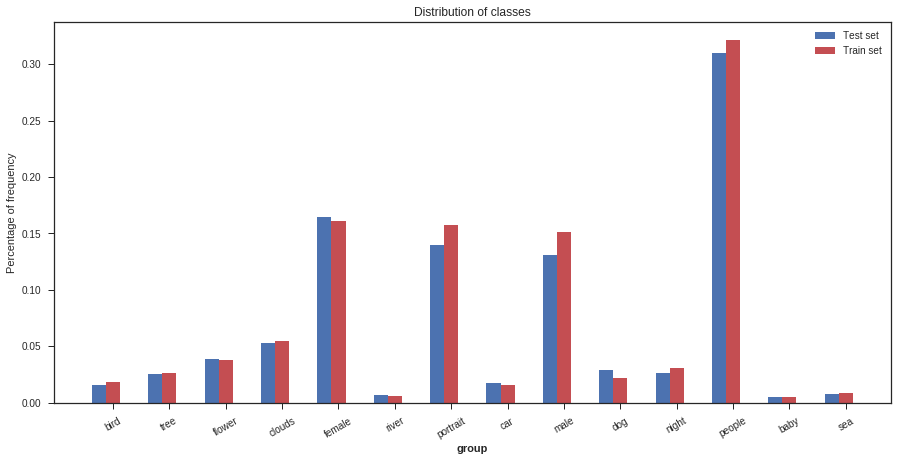

In [15]:
# NEW DISTRIBUTION IN TRAINING AND VALIDATION SET 

sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(15,7))
plt.ylabel("Percentage of frequency")
plt.xlabel("Classes")
plt.title(f"Distribution of classes")
r1 = np.arange(len(validation_data.iloc[ : , range(1,15)].sum(axis=0)))
r2 = [x + 0.25 for x in r1]

plt.bar(r1, validation_data.iloc[ : , range(1,15)].sum(axis=0)/validation_data.shape[0], width=0.25, color='b', label="Test set")
plt.bar(r2, train_data.iloc[ : , range(1,15)].sum(axis=0)/train_data.shape[0], width=0.25, color='r', label="Train set")
plt.legend()

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + 0.25 for r in range(len(validation_data.iloc[ : , range(1,15)].sum(axis=0)))], classes, rotation=30)


### Threshold

The threshold that we will use for the final output of the network is, for each class, the proportion of the data in the training set.

In [16]:
# let's take the percentage of representativeness of classes in the train set that will we use as threshold in the prevision step:
threshold_prevision = train_data.iloc[ : , range(1,15)].sum(axis=0)/train_data.shape[0]
threshold_prevision

bird        0.018222
tree        0.026333
flower      0.038000
clouds      0.055000
female      0.160944
river       0.005944
portrait    0.157833
car         0.015778
male        0.150944
dog         0.021667
night       0.030278
people      0.321278
baby        0.004722
sea         0.008778
dtype: float64

In [0]:
# save train and test data

validation_data.to_csv('./validation.csv')
train_data.to_csv('./train.csv')

In [0]:
tfs = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
])

train_dataset = ImageDataset("train.csv", transformations=tfs)
validation_dataset = ImageDataset("validation.csv")

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True,num_workers=4)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=64, shuffle=False,num_workers=4)

## Models

You can find the following models as files in the same directory of the project. To see the performance you need to load the corresponding file and run the function ***validatate_test***

### CPU or GPU

In [20]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


### Upload the model (file .pkl)

To upload the model you can use the following code (two cells). Notice that you **don't need to train** the model when you upload it.

In [21]:
from google.colab import files
files.upload()

{}

In [0]:
# To load the model you need to specify the class you want to load
# model = Inception_net()
# model = resnet

# model.load_state_dict(torch.load("model_34_all.pkl"))
# model.eval()

### Train function

In [0]:
def train(model, train_loss, epoch, pretrained=False, log_interval=100):
    model.train()
    loss_temp=0
    
    for batch_idx, databatch in enumerate(train_loader):
        data = databatch['image'].to(device).float()
        target = databatch['labels'].to(device).float()
        optimizer.zero_grad() 
        output = model(data)
        loss = criterion(output, target)
        loss_temp += loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
        
    train_loss.append(loss_temp/len(train_loader))

### Validation

Test the model in 10% of the data. The evaluation methods are:

* Precision
* Recall
* F1-score

In [0]:
from sklearn.metrics import f1_score, recall_score, precision_score
# this function calculates precision and recall FOR EACH CLASS

def validate(model, loss_vector, f1_vector, model_name, pretrained=False, save=True):  # CORRECT VALIDATION
  model.eval()
  val_loss = 0
  
  matrix_true = np.array([])
  matrix_pred = np.array([])
  
  n_batch = 0
  
  for databatch in (validation_loader):
    n_batch = n_batch+1
    data = databatch['image'].to(device).float()
    target = databatch['labels'].to(device).float()
    output = model(data)
    val_loss += criterion(output, target).data.item()

    
    if pretrained:
          output = torch.sigmoid(output)


    pred = torch.tensor(output > torch.tensor(threshold_prevision).to(device),dtype=torch.float)
    
    y_true = target.cpu().detach().numpy() # [0, 0, 1, 0 ...]
    y_pred = pred.cpu().detach().numpy() # [1, 0, 1, 0 ...]
    
    if matrix_true.shape[0] == 0:
      matrix_true = y_true
      matrix_pred = y_pred
    else:
      matrix_true = np.vstack([matrix_true, y_true])
      matrix_pred = np.vstack([matrix_pred, y_pred])
    
    # print(matrix_true.shape)
    # print(matrix_pred.shape)
  
    
  val_loss = val_loss/n_batch
  f1 = f1_score(matrix_true, matrix_pred, average='micro')
    
  recall = recall_score(y_true=matrix_true, y_pred=matrix_pred, average='micro')
  precision = precision_score(y_true=matrix_true, y_pred=matrix_pred, average='micro')
  
  print('\nValidation set: Average loss: {:.4f}'.format(val_loss))
  print("precision: {}".format(precision))
  print("recall: {}".format(recall))
  print("f1_score: {}".format(f1))
  
  loss_vector.append(val_loss)
  if val_loss == min(loss_vector) and save:
    print("save model")
    torch.save(model.state_dict(), model_name+".pkl")
  f1_vector.append(f1)

### Custom Networks

#### Custom Inception Network

This network is a custom variant of the Inception Network. The intermediate activation functions are removed and the dimensions of the filter are adapted to our image size.
By the way, it tries to follow the same idea of an Inception Network.

In [0]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

      
      
class Inception_Net(nn.Module):

    def __init__(self):
        super(Inception_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        
        self.incept1 = Inception(192,
                                  64,
                                  96,128,
                                  16,32,
                                  32)
        
        self.incept2 = Inception(256,
                                  128,
                                  128,192,
                                  32,96,
                                  64
                                 )
        
        self.incept3 = Inception(480,
                                  192,
                                  96,208,
                                  16,48,
                                  64
                                 )
        
        self.incept4 = Inception(512,
                                  160,
                                  112,224,
                                  24,64,
                                  64
                                 )
        
        self.incept5 = Inception(512,
                                  128,
                                  128,256,
                                  24,64,
                                  64
                                  )
        

        self.incept6 = Inception(512,
                                  112,
                                  144,288,
                                  32,64,
                                  64
                                  )
        
        self.incept7 = Inception(528,
                                  256,
                                  160,320,
                                  32,128,
                                  128
                                  )
        
        self.incept8 = Inception(832,
                                  256,
                                  160,320,
                                  32,128,
                                  128
                                  )
        
        self.incept9 = Inception(832,
                                  384,
                                  192,384,
                                  48,128,
                                  128
                                  )
        

        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool_2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        self.fc = nn.Linear(1024, 14)
        
        # self.dropout = nn.Dropout(0.4)

    def forward(self, x):
      
        #in_size = x.size(0)
        
        # in 128x128x3 --> out 128x126x64
        x = F.relu(self.conv1(x))
        # in 128x128x64 --> out 63x63x64
        x = self.pool_1(x)
        
        # in 63x63x64 --> out 63x63x192
        x = F.relu(self.conv2(x))
        # in 63x63x192 --> out 30x30x192
        x = self.pool_2(x)
        
        #in 30x30x192 --> out 30x30x256
        x = self.incept1(x)
        
        #in 30x30x256 --> out 30x30x480
        x = self.incept2(x)
        
        #in 30x30x480 --> out 15x15x480
        x = self.pool_1(x)
        
        #in 15x15x480 --> out 15x15x512
        x = self.incept3(x)
        
        #in 15x15x512 --> out 15x15x512
        x = self.incept4(x)
        
        #in 15x15x512 --> out 15x15x512
        x = self.incept5(x)
        
        #in 15x15x512 --> out 15x15x528
        x = self.incept6(x)
        
        #in 15x15x528 --> out 15x15x832
        x = self.incept7(x)
        

        # in 15x15x528 --> out 7x7x832
        x = self.pool_2(x)
        
        
        #in 7x7x832 --> out 7x7x832
        x = self.incept8(x)
        
        #in 7x7x832 --> out 7x7x1024 
        x = self.incept9(x)
        
        #in 7x7x1024 --> out 1x1x1024 
        x = F.avg_pool2d(x, 7)

        x = x.view(-1, 1024)  # flatten the tensor
        
        
        #in 1x29952 --> out 1x14
        x = torch.sigmoid(self.fc(x))
        
        return x

In [23]:
model1 = Inception_Net().to(device)
optimizer = torch.optim.Adam(model1.parameters())
criterion = nn.BCELoss()

print(model1)

Inception_Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (incept1): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)


In [24]:
%%time
epochs = 35

train_loss1, valid_loss1, f1_model1, save_iter1 = [], [], [], []
for epoch in range(1, epochs + 1):
  train(model1, train_loss1, epoch)
  validate(model1, valid_loss1, f1_model1, "custom_inception", save=True)

Train Epoch: 1 [0/18000 (0%)]	Loss: 0.681429
Train Epoch: 1 [6400/18000 (35%)]	Loss: 0.212165
Train Epoch: 1 [12800/18000 (71%)]	Loss: 0.187513

Validation set: Average loss: 0.1883
precision: 0.1323720930232558
recall: 0.6854527938342967
f1_score: 0.22189302978325276
save model
Train Epoch: 2 [0/18000 (0%)]	Loss: 0.176966
Train Epoch: 2 [6400/18000 (35%)]	Loss: 0.190709
Train Epoch: 2 [12800/18000 (71%)]	Loss: 0.164707

Validation set: Average loss: 0.1869
precision: 0.15701914311759343
recall: 0.6637764932562621
f1_score: 0.2539624032436417
save model
Train Epoch: 3 [0/18000 (0%)]	Loss: 0.173382
Train Epoch: 3 [6400/18000 (35%)]	Loss: 0.164124
Train Epoch: 3 [12800/18000 (71%)]	Loss: 0.175831

Validation set: Average loss: 0.1852
precision: 0.19783968163729393
recall: 0.6705202312138728
f1_score: 0.305531167690957
save model
Train Epoch: 4 [0/18000 (0%)]	Loss: 0.154381
Train Epoch: 4 [6400/18000 (35%)]	Loss: 0.186732
Train Epoch: 4 [12800/18000 (71%)]	Loss: 0.144549

Validation set: 

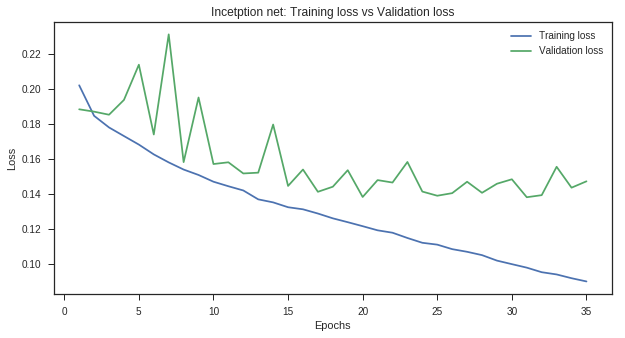

In [55]:
# training loss vs validation loss
plt.clf()
fig = plt.figure(figsize = (10,5))
plt.plot(np.arange(1,epochs+1), train_loss1, label='Training loss')
plt.plot(np.arange(1,epochs+1), valid_loss1, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title('Incetption net: Training loss vs Validation loss')

plt.show()

In [0]:
# save the model in local pc
from google.colab import files
files.download("custom_inception.pkl")

In [32]:
# load the best network
model1 = Inception_Net().to(device)
model1.load_state_dict(torch.load("custom_inception.pkl"))
model1.eval()

validate(model1, [], [], "custom_inception", save=False)


Validation set: Average loss: 0.1381
precision: 0.34024106576443225
recall: 0.7750481695568401
f1_score: 0.4728875826598089


#### Custom Residual Network

We also tried a custom version of the Residual Network. In comparison to the PyTorch implementation it doesn't have the last layer.

In [0]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [0]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [0]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.maxpool2 = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
        # self.fc1 = nn.Linear(512, 1000)
        self.fc = nn.Linear(1024, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
      
        # (16, 3, 128, 128) -> (16, 64, 64, 64)
        x = self.conv1(x)
        # batch normalization
        x = self.bn1(x)
        x = self.relu(x)
        # (16, 64, 64, 64) -> (16, 64, 32, 32)
        x = self.maxpool(x)
        
        # print("layer")
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)
        
        # final dimension after the layers (16, 512, 4, 4)
        
        # print(x.shape)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        # x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc(x))

        return x


In [0]:
import torchvision.models

def resnet(block, dim_array=[2, 2, 2, 2], pretrained=False, **kwargs):
    """Constructs a ResNet model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(block, dim_array, len(classes), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

In [0]:
# If the model is already present in the directory, use this code to load it in memory
# If you do that you don't need to train the model
# model2 = resnet(Bottleneck, dim_array=[3, 4, 6, 3]).to(device)

# model2.load_state_dict(torch.load("custom_resnet.pkl"))
# model2.eval()

# validate(model2, [], [], "custom_resnet", False)


Validation set: Average loss: 0.1811
precision: 0.13422131147540983
recall: 0.7458592132505176
f1_score: 0.2275023681717714


In [0]:
# custom version of resnet101

model2 = resnet(Bottleneck, dim_array=[3, 4, 6, 3]).to(device)
criterion = nn.BCELoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model2.parameters())

print(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
%%time
epochs = 35

train_loss2, valid_loss2, f1_model2, saved_iter2 = [], [], [], []
for epoch in range(1, epochs + 1):
  train(model2, train_loss2, epoch)
  validate(model2, valid_loss2, f1_model2, "custom_resnet", True)

Train Epoch: 1 [0/18000 (0%)]	Loss: 0.892234
Train Epoch: 1 [6400/18000 (35%)]	Loss: 0.220825
Train Epoch: 1 [12800/18000 (71%)]	Loss: 0.198993

Validation set: Average loss: 0.1841
precision: 0.1312191416635017
recall: 0.7153209109730849
f1_score: 0.22175866495507063
save model
Train Epoch: 2 [0/18000 (0%)]	Loss: 0.207821
Train Epoch: 2 [6400/18000 (35%)]	Loss: 0.179193
Train Epoch: 2 [12800/18000 (71%)]	Loss: 0.176569

Validation set: Average loss: 0.1811
precision: 0.13422131147540983
recall: 0.7458592132505176
f1_score: 0.2275023681717714
save model
Train Epoch: 3 [0/18000 (0%)]	Loss: 0.171562
Train Epoch: 3 [6400/18000 (35%)]	Loss: 0.176927
Train Epoch: 3 [12800/18000 (71%)]	Loss: 0.175854

Validation set: Average loss: 0.1852
precision: 0.138679706601467
recall: 0.7339544513457557
f1_score: 0.23328123714732255
Train Epoch: 4 [0/18000 (0%)]	Loss: 0.175784


Process Process-82:
Process Process-84:
Process Process-83:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocess

KeyboardInterrupt: ignored

In [0]:
# training loss vs validation loss
plt.clf()
plt.plot(np.arange(1,epochs+1), train_loss1, label='Training loss')
plt.plot(np.arange(1,epochs+1), valid_loss1, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title('Resnet net: Training loss vs Validation loss')

plt.show()

In [0]:
#download it in local
from google.colab import files
files.download("custom_resnet.pkl")

### Pretrained Network

The following code contains our trials with pretrained network.

In [0]:
train_dataset = ImageDataset("train.csv", transformations=tfs, resize=(224, 224))
validation_dataset = ImageDataset("validation.csv", resize=(224, 224))

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True,num_workers=4)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=64, shuffle=False,num_workers=4)

#### Resnet50

In [56]:
#Download the pretrained model
model3 = torchvision.models.resnet50(pretrained=True)

#freeze the parameter of the first layer
layer = 0
for child in model3.children():
  layer += 1
  if layer < 7:
    for param in child.parameters():
        param.requires_grad = False
        
# Change the last layer in order to fit to fit our task
model3.fc = nn.Linear(2048 , 14) 
model3.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model3.parameters())

In [58]:
%%time
epochs = 20

train_loss3, valid_loss3, f1_model3 = [], [], []
for epoch in range(1, epochs + 1):
  train(model3, train_loss3, epoch, pretrained=True)
  validate(model3, valid_loss3, f1_model3, "pretrained_resnet_50", pretrained=True, save=True)

Train Epoch: 1 [0/18000 (0%)]	Loss: 0.701958
Train Epoch: 1 [6400/18000 (35%)]	Loss: 0.163269
Train Epoch: 1 [12800/18000 (71%)]	Loss: 0.137430

Validation set: Average loss: 0.1551
precision: 0.26713728404235554
recall: 0.6926782273603083
f1_score: 0.3855744737900522
save model
Train Epoch: 2 [0/18000 (0%)]	Loss: 0.165068
Train Epoch: 2 [6400/18000 (35%)]	Loss: 0.151148
Train Epoch: 2 [12800/18000 (71%)]	Loss: 0.162016

Validation set: Average loss: 0.1378
precision: 0.3394556317769418
recall: 0.7389210019267822
f1_score: 0.4652009097801364
save model
Train Epoch: 3 [0/18000 (0%)]	Loss: 0.175631
Train Epoch: 3 [6400/18000 (35%)]	Loss: 0.114135
Train Epoch: 3 [12800/18000 (71%)]	Loss: 0.158546

Validation set: Average loss: 0.1312
precision: 0.2740899357601713
recall: 0.8015414258188824
f1_score: 0.40849392414385666
save model
Train Epoch: 4 [0/18000 (0%)]	Loss: 0.109632
Train Epoch: 4 [6400/18000 (35%)]	Loss: 0.105562
Train Epoch: 4 [12800/18000 (71%)]	Loss: 0.115457

Validation set: 

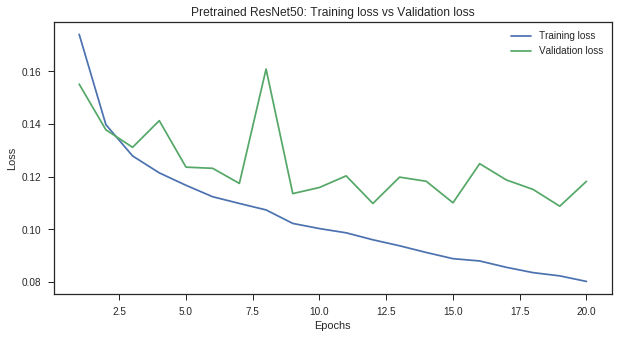

In [62]:
# training loss vs validation loss
plt.clf()
fig = plt.figure(figsize = (10,5))
plt.plot(np.arange(1,epochs+1), train_loss3, label='Training loss')
plt.plot(np.arange(1,epochs+1), valid_loss3, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title('Pretrained ResNet50: Training loss vs Validation loss')

plt.show()

In [69]:
# save the model in local pc
from google.colab import files
files.download("pretrained_resnet_50.pkl")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 60114, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [77]:
validate(model3, [], [], "pretrained_resnet_50.pkl", save=False)


Validation set: Average loss: 0.1183
precision: 0.7270354906054279
recall: 0.6710019267822736
f1_score: 0.6978957915831663


In [24]:
#Download the pretrained model
model3_x = torchvision.models.resnet50(pretrained=False)
     
# Change the last layer in order to fit to fit our task
model3_x.fc = nn.Linear(2048 , 14) 
model3_x.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [31]:
# load the best network
model3_x.load_state_dict(torch.load("pretrained_resnet_50_20.pkl"))
model3_x.eval()

validate(model3_x, [], [], "pretrained_resnet_50_20.pkl", pretrained=True, save=False)


Validation set: Average loss: 0.0798
precision: 0.43166342412451364
recall: 0.9144770736733643
f1_score: 0.5864860399801751


### Adjust threshold
Let's take the best network now. (i.e. the the one made with the pretrained Resnet50). The aim now is find a better threshold comparing to the one chosen by "default" in the start of the learning. The idea now is:
we have seen that with the current threshold we have high recall but low precision. Let's try to increase the threshold a little bit in order to increase the precision (and loose some recall) in order to maximize the F1 score.


In [0]:
def try_threshold(model, pretrained=False):
  model.eval()
  
  matrix_true = np.array([])
  matrix_pred = np.array([])
  
  
  for databatch in (validation_loader):
    data = databatch['image'].to(device).float()
    target = databatch['labels'].to(device).float()
    output = model(data)

    
    if pretrained:
          output = torch.sigmoid(output)


    pred = torch.tensor(output > torch.tensor(new_threshold_prevision).to(device),dtype=torch.float)
    
    y_true = target.cpu().detach().numpy() # [0, 0, 1, 0 ...]
    y_pred = pred.cpu().detach().numpy() # [1, 0, 1, 0 ...]
    
    if matrix_true.shape[0] == 0:
      matrix_true = y_true
      matrix_pred = y_pred
    else:
      matrix_true = np.vstack([matrix_true, y_true])
      matrix_pred = np.vstack([matrix_pred, y_pred])
    
    # print(matrix_true.shape)
    # print(matrix_pred.shape)
  
    
  
  f1 = f1_score(matrix_true, matrix_pred, average='micro')
    
  recall = recall_score(y_true=matrix_true, y_pred=matrix_pred, average='micro')
  precision = precision_score(y_true=matrix_true, y_pred=matrix_pred, average='micro')
  
  print("precision: {}".format(precision))
  print("recall: {}".format(recall))
  print("f1_score: {}".format(f1))
  
  
  

In [0]:
possible_values=[1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]

In [75]:
for i in range(len(possible_values)):
  new_threshold_prevision = threshold_prevision + possible_values[i]*threshold_prevision
  print(possible_values[i])
  try_threshold(model3_x, pretrained=True)

1.25
precision: 0.5637079455977094
recall: 0.8114374034003091
f1_score: 0.665258711721225
1.5
precision: 0.5779047619047619
recall: 0.7815558990211231
f1_score: 0.6644765659220324
1.75
precision: 0.5879705400981997
recall: 0.740340030911901
f1_score: 0.6554161915621437
2
precision: 0.5875555555555556
recall: 0.6810922205048944
f1_score: 0.6308756859937963
2.25
precision: 0.5351882160392799
recall: 0.5054095826893354
f1_score: 0.5198728139904611
2.5
precision: 0.5547866205305652
recall: 0.49562081401339514
f1_score: 0.5235374149659864
2.75
precision: 0.5659806295399515
recall: 0.4817104585265327
f1_score: 0.5204564430837739
3
precision: 0.5772200772200772
recall: 0.46213292117465227
f1_score: 0.5133047210300429


So from now let's take as threshold the "defualt" threshold + 1.25 * "defualt" threshold 

In [0]:
threshold_prevision = threshold_prevision + possible_values[i]*threshold_prevision

### Comparison among models

In [0]:
model = model3

images = test_dataset.get_images_classes(['bird'])
image = images[random.randint(0, len(images)-1)]
data = image['image'].to(device)

data = data.unsqueeze(0)

output = model(data)
pred = torch.tensor(output> torch.tensor(new_threshold ).to(device), dtype=torch.float)
y_pred = pred.cpu().detach().numpy()[0] # [1, 0, 1, 0 ...]


plt.title("Predict: "+ str(list(pd.Series(np.asarray(classes))[y_pred.astype(int)==1]))+"\n True: "+str(image['classes']))
plot_image(image['image'])

### Predictions over test set

In [44]:
# DOWNLOAD THE TEST SET and create a csv file similar to the previous one.

train_path = 'test'
dl_file = 'dl2018-image-test.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    
    #os.unlink(zip_path)

file_col = listdir("test/images")
list1 = [int(x[2:len(x)-4]) for x in file_col]
list1.sort()
listfin = ["test/images/im"+str(num)+".jpg" for num in list1]

file_col = pd.Series(listfin)

# creation of the dataframe 
df_fake = pd.DataFrame()
df_fake["fileName"] = file_col

for c in classes:
  df_fake[c] = np.zeros(df_fake.shape[0]).astype(int)

df_fake['image'] = df_fake.fileName.map(lambda f: get_thumbnail(f))
df_fake.head()
df_fake['classes'] = vec2label(df_fake)

df_fake.to_csv('./fake.csv')

In [0]:
fin_test_dataset = ImageDataset("fake.csv", resize=(224,224))

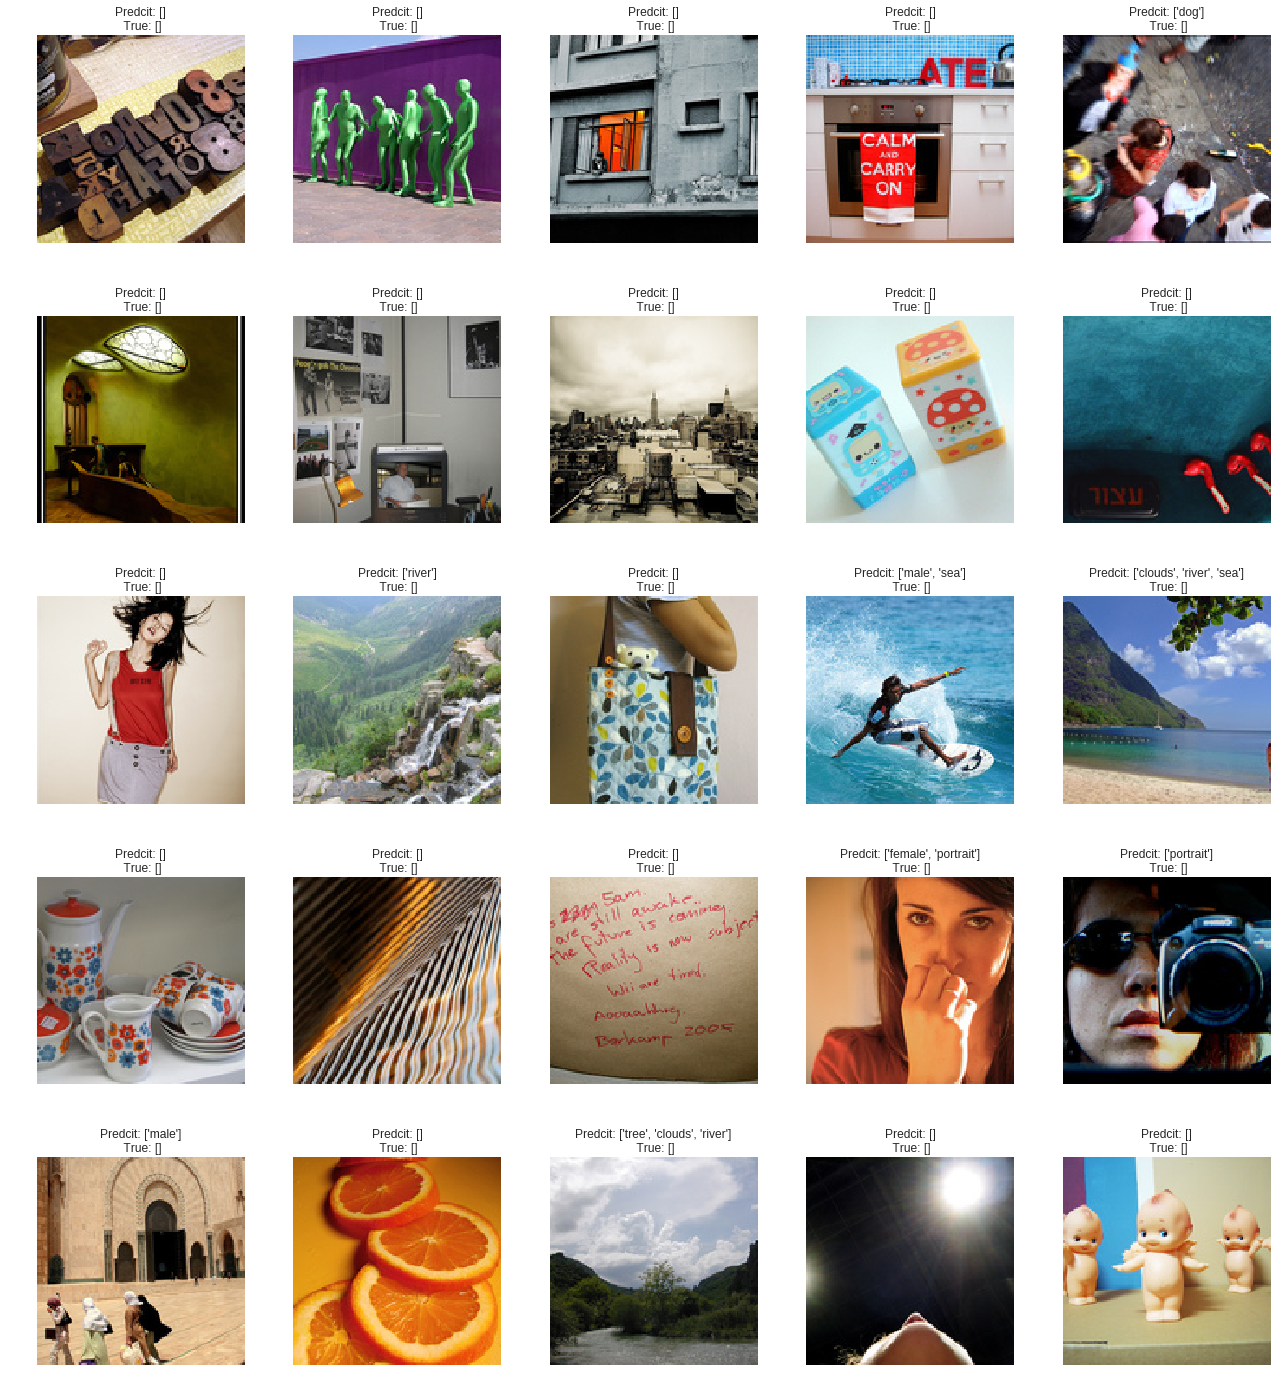

In [81]:
# FUNCTION WHICH THE FIRST 25 IMAGES IN THE TEST SET AND MAKE PREDICTIONS ON IT
# USEFUL TO UNDERSTAND IF THE NETWORK RESULTS ARE "REASONABLE"

#let's take the our best model 
model = model3_x

fig = plt.figure(figsize=(18,20))

for i in range(0,25):
    image = i
    
    data = fin_test_dataset.__getitem__(image)['image'].to(device)

    data = data.unsqueeze(0)
    
    output = model(data)
    output = torch.sigmoid(output) #we use pretarained network
    pred = torch.tensor(output> torch.tensor(threshold_prevision).to(device), dtype=torch.float)
    y_pred = pred.cpu().detach().numpy()[0] # [1, 0, 1, 0 ...]
    
    ax = plt.subplot(5, 5, i + 1)
    plt.tight_layout()
    ax.set_title("Predcit: "+ str(list(pd.Series(np.asarray(classes))[y_pred.astype(int)==1]))+"\n True: "+str(fin_test_dataset.__getitem__(image)['classes']))
    ax.axis('off')
    plot_image(fin_test_dataset.__getitem__(image)['image'])

In [0]:
# FUNCTION TO SAVE THE PREVISION OVER THE TEST SET

def test_prevision(model, pretrained=False):  
  
  matrix_pred = np.array([])
  
  for i in range(len(fin_test_dataset)):
    data = fin_test_dataset.__getitem__(i)['image'].to(device)
    data = data.unsqueeze(0)
    output = model(data)
    if pretrained==True:
      pred = torch.tensor(torch.sigmoid(output) > torch.tensor(threshold_prevision).to(device),dtype=torch.float)
    else:
      pred = torch.tensor(output> torch.tensor(threshold_prevision).to(device),dtype=torch.float)
      
    y_pred = pred.cpu().detach().numpy() # [1, 0, 1, 0 ...]
    if matrix_pred.shape[0] == 0:
      matrix_pred = y_pred
    else:
      matrix_pred = np.vstack([matrix_pred, y_pred])
      
  return (matrix_pred)

In [0]:
matrix_prevision = test_prevision(model, pretrained=True)
matrix_prevision = matrix_prevision.astype(int)
np.savetxt('results.txt', matrix_prevision, fmt='%d')